In [8]:
from multiprocessing import pool
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
import matplotlib.pyplot as plt
import os
import random
from calendar import monthrange

In [64]:
def load_data(pollutant, data_path="data/", time_step=None, time_range=None, season=None, day_of_week=None, time_of_day=None):
    """
    :param pollutant: {"CO", "NO2", "O3", "SO2", "PM10", "PM25"}
    :param data_path: path to data directory
    :param time_step: if provided, {"H", "D", "M", "Y"}
    :param time_range: if provided, get data within the given time_range, inclusive
            If second element isn't provided, defaults to present day
    :param season: true, false - creates columns for each seasons denoted by binary columns to the season datapoint belongs to
            Winter: December, January, Ferbruary
            Spring: March, April and May
            Summer: June, July and August
            Autumn: September, October and November
    :param day_of_week: true, false
            0 : weekday
            1 : weekend
    :param time_of_day: true, false
            0 : daytime
            1 : nighttime
    """
    df = pd.read_csv(f"{data_path}{pollutant}.csv", parse_dates=["date"])

    # TODO: FILTER OUT NEGATIVE VALUES FROM DF
    # get data within a given time range
    if time_range:
        start, end = time_range
        if not end:
            end = datetime.today
        df = df.loc[(df["date"] >= start) & (df["date"] <= end)]

    df = df.set_index("date")
    # daily, monthly, yearly
    if time_step in {"D", "M", "Y"}:
        index_format = {"D": "%Y-%m-%d", "M": "%Y-%m", "Y": "%Y"}
        df = df.groupby(by=["code"]).resample(time_step).mean().dropna().reset_index()
        # df["date"] = df["date"].apply(lambda x: x.strftime(index_format[time_step]))

    # seasonal buckets
    # creates binary column for each season 
    # (1 represents that the data point is part of that season, 0 represents not part of season)
    if season:
        seasons = {"winter": [12, 1, 2], 
                "spring": [i for i in range(3, 6)], 
                "summer" : [i for i in range(6, 9)], 
                "autumn" : [i for i in range(9, 12)]}

        df["Month"] = pd.DatetimeIndex(df['date']).month
        # print(df)

        # define condition: month must be within seasonal month range
        
        for s in seasons:
            # condition = (df.Month in seasons[season])
            condition = ((df.Month >= seasons[s][0]) & (df.Month <=seasons[s][-1]))
            if s == "winter":
                condition = ((df.Month >= seasons[s][0]) | (df.Month <= seasons[s][-1]))
            df[s] = np.where(condition, 1, 0)

        # drop created month column
        df = df.drop(["Month"], axis=1)
        
    # day of week buckets: weekday vs weekend
    # creates binary column for 'day_of_week' (1 represents weekday, 0 represents weekend)
    if day_of_week:
        weekdays = [i for i in range(5)]
        df["DayOfWeek"] = pd.DatetimeIndex(df['date']).dayofweek
        # condition = (df.DayOfWeek in weekdays)
        condition = ((df.DayOfWeek >= weekdays[0]) & (df.DayOfWeek <= weekdays[-1]))

        # add binary column denoting whether data point belongs to input day of week group
        df['day_of_week'] = np.where(condition, 1, 0)
        df = df.drop(["DayOfWeek"], axis=1)
        
    
    # daytime (7am - 5pm) vs nighttime (5pm - 7am) buckets, according to London's sunrise and sunset times
    # creates binary column for 'time_of_day' (1 represents daytime, 0 represents nighttime)
    if time_of_day:
        daytime_hours = [i for i in range(7, 18)]
        df["Hour"] = pd.DatetimeIndex(df['date']).hour
        # condition = (df.Hour in daytime_hours)

        condition = ((df.Hour >= daytime_hours[0]) & (df.Hour <= daytime_hours[-1]))
        if time_of_day == "night":
            condition = ((df.Hour >= daytime_hours[0]) | (df.Hour <= daytime_hours[-1]))

        df["time_of_day"] = np.where(condition, 1, 0)
        df = df.drop(["Hour"], axis=1)

    # generate time_step (t) column
    df = df.sort_values("date")
    dates = df["date"].values

    t = -1
    current_date = None
    time_steps = []
    for date in dates:
        if date != current_date:
            t += 1
            current_date = date
        time_steps.append(t)
    df["t"] = time_steps
    
    return df

In [61]:
def split_data(df, test_percent=0.2):
    """
    returns: train_df, test_df, train_indices, test_indices
    """
    N, M = df.shape
    indices = np.arange(N)
    train_indices, test_indices = train_test_split(indices, test_size=test_percent)
    train_df, test_df = df.iloc[train_indices, :], df.iloc[test_indices, :]
    return train_df, test_df

In [49]:
def scale_data(train_df, test_df, features):
    scalers = {}
    for feature in features:
        scaler = StandardScaler()
        train_df[f"scaled_{feature}"] = scaler.fit_transform(train_df[[feature]].values)
        test_df[f"scaled_{feature}"] = scaler.transform(test_df[[feature]].values)
        scalers[feature] = scaler
    return scalers

In [50]:
def train_GPR_model(kernel, train_df, x_features, y_features):
    model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2, normalize_y=True)
    model.fit(train_df[x_features], train_df[y_features])
    return model

In [51]:
def save_model(filename, df, model, train_df, test_df, train_scalers):
    path = f"GPR-models/{filename}/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    df_filename = f"{path}{filename}_df.sav"
    model_filename = f"{path}{filename}_model.sav"
    train_df_filename = f"{path}{filename}_train_df.sav"
    test_df_filename = f"{path}{filename}_test_df.sav"
    scalers_filename = f"{path}{filename}_scalers.sav"
    pickle.dump(df, open(df_filename, "wb"))
    pickle.dump(model, open(model_filename, "wb"))
    pickle.dump(test_df, open(train_df_filename, "wb"))
    pickle.dump(train_df, open(test_df_filename, "wb"))
    pickle.dump(train_scalers, open(scalers_filename, "wb"))

In [52]:
def plot_model(model, train_df, test_df, x_fixed_features, x_features, y_features, scalers, codes, title="Predictions after training", save_path="GPR_figures/"):
    min_t, max_t = df["t"].min(), df["t"].max()
    time_steps = np.linspace(min_t, max_t, max_t-min_t+1)
    start_date, end_date = df["date"].min(), df["date"].max()
    delta = end_date - start_date
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)]
    
    for code in codes:
        plt.figure()
        plt.subplots(facecolor="white")
        
        site_train_df, site_test_df = train_df.loc[train_df["code"] == code], test_df.loc[test_df["code"] == code]
        
        # PREDICT POLLUTION AT SITE ACROSS ALL DATES IN TIME RANGE
        site_prediction_df = pd.DataFrame({"t": time_steps})
        for fixed_feature in x_fixed_features:
            site_prediction_df[fixed_feature] = site_train_df.iloc[0][fixed_feature]
        site_prediction_df = site_prediction_df[x_features]
        
        # PLOT PREDICTION
        prediction_mean, prediction_std = model.predict(site_prediction_df, return_std=True)
        prediction_mean, prediction_std = prediction_mean.flatten(), prediction_std.flatten()
        (line,) = plt.plot(dates, prediction_mean, lw=1.5, label="Mean of predictive posterior")
        plt.fill_between(
            dates,
            prediction_mean-1.96*prediction_std,
            prediction_mean+1.96*prediction_std,
            color=line.get_color(),
            alpha=0.6,
            label=r"95% confidence interval"
        )
        
        # PLOT OBSERVED (TRAIN) DATA
        plt.plot(site_train_df["date"], site_train_df[y_features], "x", label="Training observations", alpha=0.9, color="grey", linestyle="None")
        
        # PREDICT TEST DATA
        test_mean, test_std = model.predict(site_test_df[x_features], return_std=True)
        test_mean, test_std = test_mean.flatten(), test_std.flatten()

        # PLOT TEST ACTUAL VALUE
        plt.plot(site_test_df["date"], site_test_df[y_features], ".", label="Testing actual value", alpha=0.75, color="red", linestyle="None")
        
        # PLOT DIFFERENCE BETWEEN TEST PREDICTION AND ACTUAL VALUE
        test_dates = site_test_df["date"].values
        plt.plot((test_dates, test_dates), (test_mean, site_test_df[y_features].values.flatten()), c='red')# , label="Prediction error")
        
        # PLOT TEST PREDICTION
        plt.plot(site_test_df["date"], test_mean, "o", label="Testing predictions", alpha=0.75, color="blue", linestyle="None")
        # percent_error = np.absolute(1 - np.divide(test_mean, site_test_df[y_features].values.flatten()))*100
        # plt.scatter(site_test_df["date"], test_mean, c=percent_error, vmin=0, vmax=round(np.max(percent_error)), cmap="bwr", label="Testing points")
        # plt.colorbar()
        
        # SCORE TEST DATA
        score = model.score(site_test_df[x_features], site_test_df[y_features])
        
        plt.title(f"Model predictions for site {code}\n Test score (n={site_test_df.shape[0]}): {score}")
        plt.xlabel(f"Date")
        plt.ylabel(f"Concentration of NO2 (ug/m3)")

        # create folder for model run
        isExist = os.path.exists(save_path)
        if not isExist:
            os.makedirs(save_path)

        plt.gcf().autofmt_xdate()
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.legend(loc=(1.04,0))
        
        plt.savefig(fname=save_path + "prediction_" + code + ".png")
        plt.close()

In [53]:
"""
SPECIFY DATA PARAMETERS
"""
pollutant = "NO2"
time_step = "D"
time_range = (datetime(2020, 9, 1), datetime(2020, 12, 31))
season = True
day_of_week = True
time_of_day = True
field_strings = filter(None, [pollutant, time_step, time_range[0].strftime("%m%d%Y"), time_range[1].strftime("%m%d%Y"), str(season), str(day_of_week), str(time_of_day)])

random_id = random.randint(0, 10000)
figure_title = "_".join(field_strings)
filename = figure_title = f"{random_id}_{figure_title}"

In [54]:
filename

'8051_NO2_D_09012020_12312020_True_True_True'

In [65]:
alex_data_path = "../../data/"
ana_data_path = "../data-collection/LAQN_API_data/"
df = load_data(pollutant, data_path=ana_data_path, time_step=time_step, time_range=time_range, season=season, day_of_week=day_of_week, time_of_day=time_of_day)

winter
spring
summer
autumn
      code       date        no2   latitude  longitude  winter  spring  \
0      BG1 2020-09-01  18.766667  51.563752   0.177891       0       0   
1      BG1 2020-09-02  19.266667  51.563752   0.177891       0       0   
2      BG1 2020-09-03   9.825000  51.563752   0.177891       0       0   
3      BG1 2020-09-04  12.375000  51.563752   0.177891       0       0   
4      BG1 2020-09-05  16.560870  51.563752   0.177891       0       0   
...    ...        ...        ...        ...        ...     ...     ...   
10402  WMD 2020-12-27  23.254167  51.492248  -0.147115       1       0   
10403  WMD 2020-12-28  30.925000  51.492248  -0.147115       1       0   
10404  WMD 2020-12-29  25.375000  51.492248  -0.147115       1       0   
10405  WMD 2020-12-30  42.866667  51.492248  -0.147115       1       0   
10406  WMD 2020-12-31  53.300000  51.492248  -0.147115       1       0   

       summer  autumn  
0           0       1  
1           0       1  
2          

In [63]:
df.head()

,code,date,no2,latitude,longitude,winter,spring,summer,autumn,day_of_week,True,time_of_day,t
0,BG1,2020-09-01,18.766667,51.563752,0.177891,0,0,0,1,1,0,0,0
8141,SK8,2020-09-01,55.645833,51.501391,-0.078203,0,0,0,1,1,0,0,0
9977,WM6,2020-09-01,49.987500,51.513929,-0.152793,0,0,0,1,1,0,0,0
2835,GB6,2020-09-01,46.604167,51.456300,0.085606,0,0,0,1,1,0,0,0
8061,SK6,2020-09-01,36.733333,51.493156,-0.101527,0,0,0,1,1,0,0,0


In [214]:
train_df, test_df = split_data(df)

In [215]:
scaled_features = ["latitude", "longitude"]
train_scalers = scale_data(train_df, test_df, ["latitude", "longitude"])

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [216]:
"""
SPECIFY KERNEL PARAMETERS
"""
PERIODICITY = 7
kernel = kernels.ExpSineSquared(periodicity=PERIODICITY)*kernels.RBF([0, 0, 1.0]) + kernels.RBF([1.0, 1.0, 0])

In [217]:
x_features = ["scaled_latitude", "scaled_longitude", "t", "day_of_week", "time_of_day"]
y_features = ["no2"]
model = train_GPR_model(kernel, train_df, x_features, y_features)

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernel

In [218]:
save_model(filename, df, model, train_df, test_df, train_scalers)

In [219]:
model.feature_names_in_

array(['scaled_latitude', 'scaled_longitude', 't'], dtype=object)

In [220]:
model.score(test_df[x_features], test_df[y_features])

0.8447019152634144

In [221]:
test_df.head()

,code,date,nox,no2,latitude,longitude,t,scaled_latitude,scaled_longitude
6085,LB5,2020-10-01,82.623542,40.469735,51.485487,-0.124545,30,-0.231456,-0.206121
4823,HR1,2020-12-20,20.326494,18.649158,51.617327,-0.298775,110,1.968695,-1.484283
1653,CT3,2020-09-09,22.204179,17.410888,51.513847,-0.077766,8,0.241823,0.137058
242,BG2,2020-12-30,89.483204,36.990038,51.529389,0.132857,120,0.501185,1.682202
1169,BY7,2020-09-30,32.859231,20.637903,51.405546,0.018882,29,-1.565508,0.846073


/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

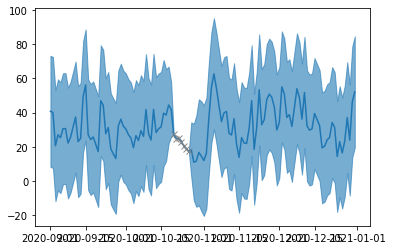

In [222]:
x_fixed_features = ["scaled_latitude", "scaled_longitude"]
site_codes = df["code"].unique()
save_path = f"GPR_figures/{filename}/"
plot_model(model, train_df, test_df, x_fixed_features, x_features, y_features, train_scalers, site_codes, save_path=save_path)

In [ ]:
"""
TRANSFORM SAVED MODELS TO FIT THIS NEW WORKFLOW
"""
filename = "2679_NO2_D_09012020_12312020"
df = pickle.load(open(f"{filename}_df.sav", "rb"))

df = df.sort_values("date")
dates = df["date"].values

t = -1
current_date = None
time_steps = []
for date in dates:
    if date != current_date:
        t += 1
        current_date = date
    time_steps.append(t)
df["t"] = time_steps

df = df.rename(columns={'norm_lat': 'scaled_latitude', 'norm_lon': 'scaled_longitude'})
    
model = pickle.load(open(f"{filename}_model.sav", "rb"))
train_indices, test_indices = pickle.load(open(f"{filename}_indices.sav", "rb"))
train_scalers = pickle.load(open(f"{filename}_scalers.sav", "rb"))
site_codes = df["code"].unique()
train_df, test_df = df.iloc[train_indices, :], df.iloc[test_indices, :]